In [27]:
# importing necessary libraries

import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [14]:
# downloading the xception model
model = keras.applications.xception.Xception(weights="imagenet")

In [15]:
# get the file path
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

# make a function which takes file path, loads image, converts into array
# converts into batch, preprocess_input based on image, return array
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

# get image array
img_array = get_img_array(img_path, target_size=(299, 299))

In [16]:
# making prediction on the downloaded image using the xception model
pred = model.predict(img_array)

# obtaining the top 3 predicted classes on the image by the model
top_3 = keras.applications.xception.decode_predictions(pred, top=3)

In [17]:
# seeing the top 3 most probable classes on the image, according to xception model
top_3[0]

[('n02504458', 'African_elephant', 0.8699266),
 ('n01871265', 'tusker', 0.076968715),
 ('n02504013', 'Indian_elephant', 0.023537282)]

In [18]:
# the highest probability class
np.argmax(pred[0])

386

### Grad-CAM process to visualize the heatmap of the most predicted class like parts of the input image

1. Setting up model that returns the activation of last convolution layer

In [19]:
# specifying the layer name
last_conv_layer_name = "block14_sepconv2_act"

# specifying the output layer names
classifier_layer_names = [
                          "avg_pool",
                          "predictions"
]

# obtaining the last conv layer
last_conv_layer = model.get_layer(last_conv_layer_name)

# making the model which connects the xception input to last conv layer output
last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)

2. Reapplying the classifier on top of the last convolution output

In [20]:
# specifying the input on the classifier model, which is the last conv layer activation
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

# including the layers after the last conv layer (global average pooling and predictions dense layer)
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)

# making model 
classifier_model = keras.Model(classifier_input, x)

3. Compute the gradient of the top predicted class for our input image with respect to the activations of last convolution layer.

In [21]:
# open gradient tape scope
with tf.GradientTape() as tape:
    # output of last conv layer
    last_conv_layer_output = last_conv_layer_model(img_array)
    # watch the last layer activation
    tape.watch(last_conv_layer_output)
    # get the softmax predictions via the classifier
    preds = classifier_model(last_conv_layer_output)
    # the class having highest value (probability)
    top_pred_index = tf.argmax(preds[0])
    # highest probability class channel
    top_class_channel = preds[:, top_pred_index]

# gradient of the top class channel w.r.t. last convolution layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

4. Apply pooling and gradient importance weighting to the gradient tensor to obtain our heatmap of class activation

In [22]:
# reducing each channel from 10X10 array to 1 single mean value
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
# removing the batch dimension
last_conv_layer_output = last_conv_layer_output.numpy()[0]
# multiplying each channel of last layer activation with how important the channel is
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
# taking the mean of all the channels to obtain a 2D tensor
heatmap = np.mean(last_conv_layer_output, axis=-1)

5. Visualizing the heatmap

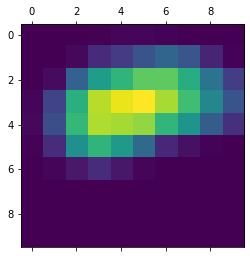

In [23]:
# taking the element wise maximum between 0 and the element in heatmap
heatmap = np.maximum(heatmap, 0)
# min max scaling of the values
heatmap /= np.max(heatmap)
# visualizing the heatmap
plt.matshow(heatmap)
plt.show()

6. Superimposing the heatmap over the original picture

In [24]:
# getting the original image
img = keras.utils.load_img(img_path)
# converting to array for computations
img = keras.utils.img_to_array(img)

# rescale the heatmap to 0-255
heatmap = np.uint8(255 * heatmap)

# use the "jet" colormap to recolorize the heatmap
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# resizing the heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# superimposing the heatmap at 40% opacity
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

7. See the superimposed image

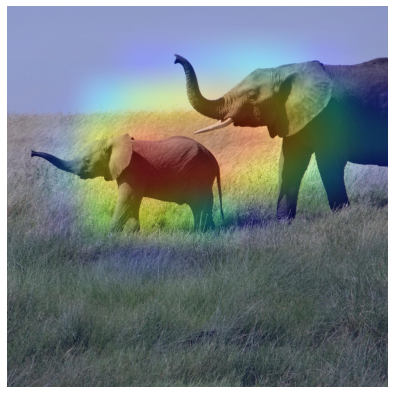

In [29]:
si_img = mpimg.imread("elephant_cam.jpg")
plt.figure(figsize=(10, 7))
plt.axis("off")
plt.imshow(si_img)
plt.show()